## **07-3) 신경망 모델 훈련**

인공 신경망 모델을 훈련하는 모범 사례와 필요한 도구들을 살펴본다.

#### **용어 정리**
- **드롭 아웃**: 은닉층에 있는 뉴런의 출력을 랜덤하게 꺼서 과대적합을 막는 기법. 드롭아웃은 훈련 중에 적용되며 평가나 예측에서는 적용하지 않는다. 텐서플로는 이를 자동으로 처리해준다.

- **콜백**: 케라스 모델을 훈련하는 도중에 어떤 작업을 수행할 수 있도록 도와주는 도구. 대표적으로 최상의 모델을 자동으로 저장해주거나 검증 점수가 더 이상 향상되지 않으면 일찍 종료할 수 있다.

- **조기 종료**: 검증 점수가 더 이상 감소하지 않고 상승하여 과대적합이 일어나면 훈련을 계속 진행하지 않고 멈추는 기법으로, 계산 비용과 시간을 절약할 수 있다.

<br><hr><br>

### **손실 곡선**

케라스의 fit() 메서드는 **History 클래스 객체**를 반환한다.<br>
History 객체에는 훈련 과정에서 계산한 지표인 손실과 정확도 값이 저장되어 있다.<br>
이 값을 사용하여 그래프를 그려볼 것이다.

먼저 패션 MNIST 데이터셋을 적재하고 훈련 세트와 검증 세트로 나눈다.

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


그다음 모델을 만들 건데, 이번에는 모델을 만드는 간단한 함수를 정의해볼 것이다.

In [3]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28))) # Flatten
    model.add(keras.layers.Dense(100, activation='relu')) # relu
    if a_layer: # 케라스 층을 추가하면 은닉층 뒤에 하나의 층 추가
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [4]:
# 매개변수로 층 추가하지 않고 모델 생성
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


이전 절과 동일하게 모델을 훈련하지만 fit() 메서드의 결과를 history 변수에 담을 것이다.

In [5]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

- **verbose**: 훈련 과정 출력 조절
  - verbose=0: 훈련 과정 나타내지 않음
  - verbose=1: 에포크마다 진행 막대와 함께 손실 등 지표 출력
  - verbose=2: 진행 막대 빼고 출력

history 객체에는 훈련 측정값이 담겨 있는 history 딕셔너리가 들어있다.

In [6]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


이 딕셔너리에는 손실과 정확도가 포함되어 있다. <br>
compile() 메서드에서 metrics='accuracy'를 지정해줬기 때문에 history 속성에 정확도가 추가된 것이다.

history 속성에 포함된 손실과 정확도는 에포크마다 계산한 값이 순서대로 나열된 단순한 리스트로, 맷플롯립을 사용해 그래프로 그려볼 수 있다.

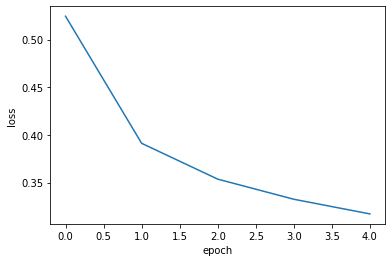

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

이번에는 정확도를 출력해보자.

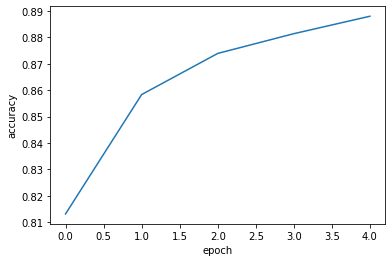

In [8]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

확실히 에포크마다 손실이 감소하고 정확도가 향상한다.

그럼 이번에는 에포크 횟수를 20으로 늘려서 모델을 훈련하고 손실 그래프를 그려볼 것이다.<br>
예상대로 손실이 잘 감소하는 것을 확인할 수 있다.

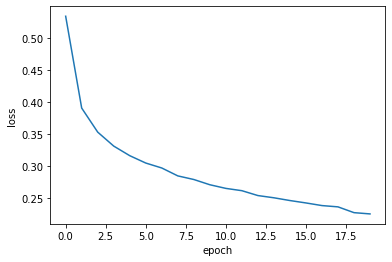

In [9]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

<br><hr><br>

### **검증 손실**

에포크에 따른 과대적합과 과소적합을 파악하려면 훈련 세트뿐만 아니라 검증 세트에 대한 점수도 필요하다.<br>
이번에는 손실을 사용하여 과대/과소 적합을 다뤄볼 것이다.

에포크마다 검증 손실을 계산하기 위해 케라스 모델의 fit() 메서드에서 validation_data 매개변수를 지정한다.<br>
검증에 사용할 입력과 타깃값을 튜플로 전달하면 된다.

In [10]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

 반환된 history.history 딕셔너리에 어떤 값이 들어있는지 키를 확인해보자.

In [11]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


검증 세트에 대한 손실은 'val_loss', 정확도는 'val_accuracy'에 들어있다.

과대/과소적합 문제를 조사하기 위해 훈련 손실과 검증 손실을 한 그래프에 그려 비교해볼 것이다.

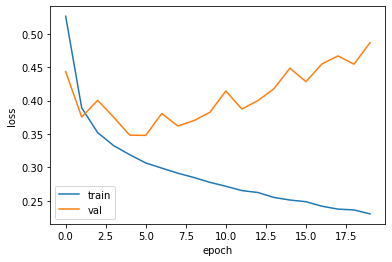

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

초기에 검증 손실이 감소하다가 5번째 에포크 만에 다시 상승한다.<br>
훈련 손실은 꾸준히 감소하기 때문에 전형적인 과대적합 모델이 만들어진다.

검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들 뿐만 아니라 검증 세트에 대한 정확도도 증가할 것이다.

옵티마이저 하이퍼파라미터를 조정하여 과대적합을 완화해보자.<br>
Adam 옵티마이저를 적용해보고 훈련 손실과 검증 손실을 다시 그려볼 것이다.

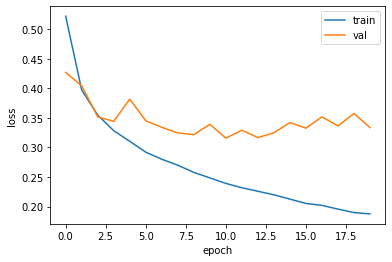

In [13]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대적합이 많이 줄었다. 열 번째 에포크까지 전반적인 감소 추세가 이어지고 있다.<br>
이는 Adam 옵티마이저가 이 데이터셋에 잘 맞는다는 것을 의미한다.

<br><hr><br>

### **드롭아웃** 

**드롭아웃**은 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서(뉴런의 출력을 0으로 만들어서) 과대적합을 방지한다.

또한, 드롭아웃을 적용해 훈련하는 것은 마치 2개의 신경망을 앙상블 하는 것처럼 상상할 수 있다.<br>
앙상블은 과대적합을 막을 수 있는 아주 좋은 기법이다.

+) **앙상블**: 더 좋은 예측 결과를 만들기 위해 여러 개의 모델을 훈련하는 머신러닝 알고리즘

케라스에서는 드롭아웃을 keras.layers 패키지 아래 Dropout 클래스로 제공한다.<br>
드롭아웃이 층처럼 사용되지만 훈련되는 모델 파라미터는 없다.

그럼 앞서 정의한 model_fn() 함수에 드롭아웃 객체를 전달하여 층을 추가해볼 것이다.<br>
여기서는 30% 정도를 드롭아웃한다.

In [14]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


드롭아웃 층은 입력과 출력의 크기가 같다 
<br> 
또한 일부 뉴런의 출력을 0으로 만들지만, 전체 출력 배열의 크기를 바꾸지는 않는다.

이전과 마찬가지로 훈련 손실과 검증 손실의 그래프를 그려 비교해보자.

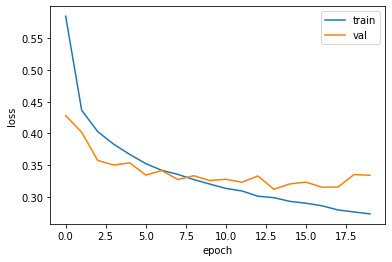

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대적합이 확실히 줄었다. 열 번째 에포크 정도에서 검증 손실의 감소가 멈추지만 크게 상승하지 않고 어느 정도 유지되고 있다.<br>
그러나 이 모델은 20번의 에포크 동안 훈련을 했기 때문에 결국 다소 과대적합되어 있다.<br>
과대적합되지 않은 모델을 얻기 위해서는 에포크 횟수를 10으로 하고 다시 훈련해야 할 것이다.

<br><hr><br>

### **모델 저장과 복원**

에포크 횟수를 다시 10으로 지정하고 모델을 훈련한다.

In [16]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))

케라스의 **save_weights()** 메서드를 사용하면 훈련된 모델의 파라미터를 저장할 수 있다.<br>
이 메서드는 기본적으로 텐서플로의 체크포인트 포맷으로 저장하지만, 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다.

In [17]:
model.save_weights('model-weights.h5')

save() 메서드를 사용하면 모델 구조와 모델 파라미터를 함께 저장할 수 있다.<br>
이 메서드는 기본적으로 텐서플로의 SavedModel 포맷으로 저장하지만, 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다.

In [18]:
model.save('model-whole.h5')

두 파일이 잘 만들어졌는지 확인해보자.

In [19]:
!ls -al *.h5

-rw-r--r-- 1 root root 333448 Jul  7 14:43 model-weights.h5
-rw-r--r-- 1 root root 982664 Jul  7 14:44 model-whole.h5


이제 두 가지 실험을 해볼 것이다.<br>
1. 훈련을 하지 않은 새로운 모델을 만들고 model-weight.h5 파일에서 훈련된 모델 파라미터를 읽어서 사용한다.

2. 아예 model-whole.h5 파일에서 새로운 모델을 만들어 바로 사용한다.

<br><br>

**1. 훈련을 하지 않은 새로운 모델을 만들고 model-weight.h5 파일에서 훈련된 모델 파라미터를 읽어서 사용**

In [20]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5') # save_weights로 저장한 파일은 load_weights로 적재

이제 이 모델의 검증 정확도를 확인해볼 건데, 케라스에서 예측을 수행하는 predict() 메서드는 사이킷런과 달리 샘플마다 10개의 클래스에 대한 확률을 반환한다.
패션 MNIST 데이터셋이 다중 분류이기 때문인데, 10개 확률 중에 가장 큰 값의 인덱스를 골라 타깃 레이블과 비교하여 정확도를 계산해보도록 하자.

In [21]:
import numpy as np

# axis=-1 ~> 배열의 마지막 차원을 따라 최댓값 고름
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

0.8793333333333333


<br><br>

**2. model-whole.h5 파일에서 새로운 모델을 만들어 바로 사용**

In [22]:
model = keras.models.load_model('model-whole.h5') # 모델이 저장된 파일 읽을 때 ~> load_model()
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3360 - accuracy: 0.8793


[0.3360385596752167, 0.8793333172798157]

방법 1,2는 같은 모델을 저장하고 다시 불러들였기 때문에 동일한 정확도를 얻는다.

<br><hr><br>

### **콜백**

**콜백**은 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 keras.callbacks 패키지 아래에 있는 클래스들이다.<br>
fit() 메서드의 callbacks 매개변수에 리스트로 전달하여 사용한다.

**ModelCheckpoint** 콜백은 기본적으로 에포크마다 모델을 저장한다.<br>
**save_best_only=True** 매개변수를 지정하여 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있다.

In [23]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

best-model.h5에 저장된 모델을 다시 읽어서 예측을 수행해보자.

In [24]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3117 - accuracy: 0.8863


[0.3117174208164215, 0.8863333463668823]

하지만 여전히 20번의 에포크 동안 훈련을 하고 있으니, 과대적합이 시작되기 전에 훈련을 **조기종료**를 하는 것이 좋다.

케라스는 조기종료를 위한 **EarlyStopping 콜백**을 제공한다.
- **patience**: 검증 점수가 향상되지 않더라도 참을 에포크 횟수
- **restore_best_weights=True**: 가장 낮은 검증 손실을 낸 모델 파라미터로 복구

EarlyStopping 콜백을 ModelCheckpoint 콜백과 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련을 중지할 수 있다.<br>
또한 훈련을 중지한 다음 현재 모델의 파라미터를 최상의 파라미터로 되돌린다.

In [25]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

훈련을 마치고 난 후 몇 번째 에포크에서 훈련이 중지되었는지는 **early_stopping_cb 객체**의 **`stopped_epoch 속성`**에서 확인할 수 있다.

In [26]:
print(early_stopping_cb.stopped_epoch)

11


훈련 손실과 검증 손실을 출력해서 확인해보자.

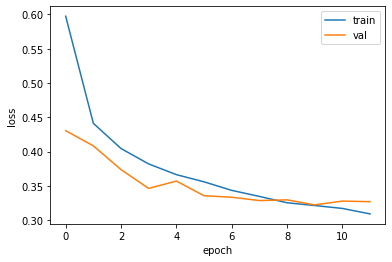

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

마지막으로 조기 종료로 얻은 모델을 사용해 검증 세트에 대한 성능을 확인해보자.

In [28]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3224 - accuracy: 0.8817


[0.3224020004272461, 0.8817499876022339]